<a href="https://colab.research.google.com/github/heehehe/kakao_arena_melon/blob/master/modeling_by_title" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###패키지 import & data 불러오기

In [ ]:
!git clone https://github.com/kakao/khaiii.git
!pip install cmake
!mkdir build
!cd build && cmake /content/khaiii
!cd /content/build/ && make all
!cd /content/build/ && make resource
!cd /content/build && make install
!cd /content/build && make package_python
!pip install /content/build/package_python

In [2]:
### colab 사용 시 실행
from google.colab import drive
drive.mount('/content/gdrive/')
import os
os.chdir('gdrive/My Drive/Google Colaboratory/kakao_arena/kakao_arena_melon/src/ipynb')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
import sys
sys.path.append('../')
from basic_utils import *

import re
from khaiii import KhaiiiApi
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
data_path = './../../../1_melon_playlist/data/'

train = pd.read_json(data_path+'train.json')
val = pd.read_json(data_path+'val.json')
# test = pd.read_json(data_path+'test.json')
# song_meta = load_json(data_path+'song_meta.json')
# genre_gn_all = pd.read_json(data_path+'genre_gn_all.json', typ = 'series')

### make_file.ipynb 내에서 만들어진 tag_song_dict / song_tag_dict 불러오기
tag_song_dict = load_json(data_path+'tag_song_dict_no0.json')
song_tag_dict = load_json(data_path+'song_tag_dict.json')

In [ ]:
train.head(2)

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000


#### tag 형태소 분석

In [ ]:
print('train에서 title 존재 데이터 개수 : {}개 ({}%)'.format(len(train[train['plylst_title']!='']), len(train[train['plylst_title']!=''])/len(train)*100))
print('val에서 title 존재 데이터 개수   : {}개 ({}%)'.format(len(val[val['plylst_title']!='']),     len(val[val['plylst_title']!=''])/len(val)*100))
print('test에서 title 존재 데이터 개수  : {}개 ({}%)'.format(len(test[test['plylst_title']!='']),   len(test[test['plylst_title']!=''])/len(test)*100))

train에서 title 존재 데이터 개수 : 115071개 (100.0%)
val에서 title 존재 데이터 개수   : 4373개 (19.00065174885944%)
test에서 title 존재 데이터 개수  : 2041개 (19.00372439478585%)


In [ ]:
def flatten(df_col):
    # nested list 풀기
    list_of_list = df_col.values.tolist()
    flatten = [j for i in list_of_list for j in i]
    return flatten

# def get_all(df) -> List:
#     tag_list = df['tags'].values.tolist()
#     tag_list = flatten(tag_list)
#     return tag_list

def do_khaiii(data):
    api = KhaiiiApi()
    morphs_prep = []
    for d in data:
        try:
            for word in api.analyze(d):
                for w in word.morphs:
                    if len(w.lex) > 1 or w.tag not in ['ETM','ETN','XSA','JX','VV']:
                        morphs_prep.append((w.lex, w.tag))
        except:
            pass # 비어있는 경우
    gc.collect()
    return morphs_prep

# api = KhaiiiApi()
# tag_morphs = []
# for tag in train['tags']:
#     for t in tag:
#         try:
#             for word in api.analyze(t):
#                 for w in word.morphs:
#                     tag_morphs.append((w.lex, w.tag))
#         except:
#             pass # 비어있는 경우

def do_khaiii_col(data):
    api = KhaiiiApi()
    morphs_prep = ['']*len(data)
    for i,d in enumerate(data):
        try:
            for word in api.analyze(d):
                for w in word.morphs:
                    if len(w.lex) > 1 or w.tag not in ['ETM','ETN','XSA','JX','VV']:
                        morphs_prep[i] = (w.lex, w.tag)
        except:
            pass # 비어있는 경우
    gc.collect()
    return morphs_prep

In [ ]:
tags_list = flatten(train['tags'])
songs_list = flatten(train['songs'])

In [ ]:
print(len(tags_list))
print(len(songs_list))

476331
5285871


In [ ]:
tag_morphs = []
for tag in tqdm(tags_list):
    tag_morphs.extend(do_khaiii(tag))

In [ ]:
len(tag_morphs)

722860

In [ ]:
# Counter([t[0] for t in tag_morphs]).most_common()
Counter(tag_morphs).most_common()[:30]

[(('ㄴ', 'ETM'), 26970),
 (('하', 'XSA'), 21926),
 (('기분', 'NNG'), 17443),
 (('전환', 'NNG'), 16543),
 (('감성', 'NNG'), 14411),
 (('휴식', 'NNG'), 11385),
 (('발라드', 'NNG'), 10798),
 (('잔잔', 'XR'), 10526),
 (('드라이브', 'NNG'), 10212),
 (('힐링', 'NNG'), 9871),
 (('새벽', 'NNG'), 9422),
 (('사랑', 'NNG'), 9418),
 (('힙합', 'NNG'), 8983),
 (('밤', 'NNG'), 8765),
 (('음악', 'NNG'), 8649),
 (('는', 'JX'), 8462),
 (('카페', 'NNG'), 7776),
 (('팝', 'NNG'), 7373),
 (('추억', 'NNG'), 6841),
 (('ㅁ', 'ETN'), 6388),
 (('매장', 'NNG'), 6124),
 (('인디', 'NNG'), 5594),
 (('이별', 'NNG'), 5505),
 (('설', 'NNP'), 5090),
 (('나', 'VV'), 5027),
 (('신', 'NNG'), 4988),
 (('레', 'VV'), 4912),
 (('여행', 'NNG'), 4857),
 (('회상', 'NNG'), 4736),
 (('겨울', 'NNG'), 4727)]

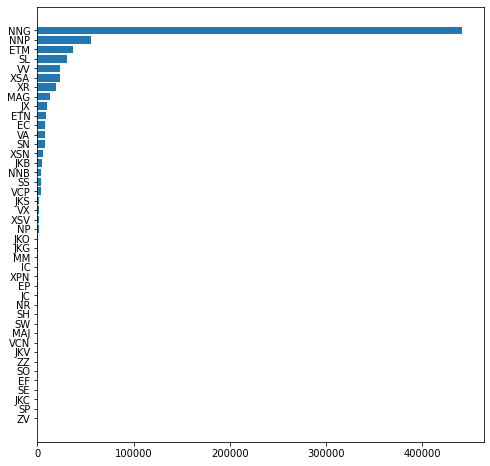

In [ ]:
tag_morphs_counter = Counter([t[1] for t in tag_morphs]).most_common()
tag_morphs_list = [t[0] for t in tag_morphs_counter]
tag_morphs_cnt = [t[1] for t in tag_morphs_counter]

plt.figure(figsize=(8,8))
plt.barh(tag_morphs_list[::-1], tag_morphs_cnt[::-1])
plt.show()

In [ ]:
tag_morphs_counter

In [ ]:
api = KhaiiiApi()

tag_morphs_prep = []
for tag in train['tags']:
    for t in tag:
        try:
            for word in api.analyze(t):
                for w in word.morphs:
                    if len(w.lex) > 1 or w.tag not in ['ETM','ETN','XSA','JX','VV']:
                        tag_morphs_prep.append((w.lex, w.tag))
        except:
            pass # 비어있는 경우

In [ ]:
len(tag_morphs_prep)

623244

In [ ]:
Counter(tag_morphs_prep).most_common()[:30]

[(('기분', 'NNG'), 17443),
 (('전환', 'NNG'), 16543),
 (('감성', 'NNG'), 14411),
 (('휴식', 'NNG'), 11385),
 (('발라드', 'NNG'), 10798),
 (('잔잔', 'XR'), 10526),
 (('드라이브', 'NNG'), 10212),
 (('힐링', 'NNG'), 9871),
 (('새벽', 'NNG'), 9422),
 (('사랑', 'NNG'), 9418),
 (('힙합', 'NNG'), 8983),
 (('밤', 'NNG'), 8765),
 (('음악', 'NNG'), 8649),
 (('카페', 'NNG'), 7776),
 (('팝', 'NNG'), 7373),
 (('추억', 'NNG'), 6841),
 (('매장', 'NNG'), 6124),
 (('인디', 'NNG'), 5594),
 (('이별', 'NNG'), 5505),
 (('설', 'NNP'), 5090),
 (('신', 'NNG'), 4988),
 (('여행', 'NNG'), 4857),
 (('회상', 'NNG'), 4736),
 (('겨울', 'NNG'), 4727),
 (('여름', 'NNG'), 4358),
 (('가을', 'NNG'), 4169),
 (('비', 'NNG'), 4166),
 (('스트레스', 'NNG'), 4163),
 (('노래', 'NNG'), 4077),
 (('락', 'MAG'), 4026)]

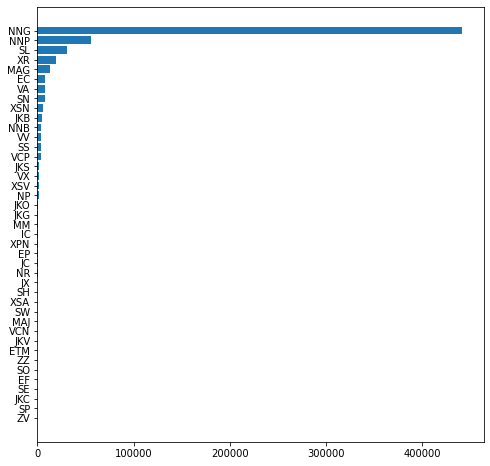

In [ ]:
tag_morphs_counter = Counter([t[1] for t in tag_morphs_prep]).most_common()
tag_morphs_list = [t[0] for t in tag_morphs_counter]
tag_morphs_cnt = [t[1] for t in tag_morphs_counter]

plt.figure(figsize=(8,8))
plt.barh(tag_morphs_list[::-1], tag_morphs_cnt[::-1])
plt.show()

In [ ]:
tag_morphs_counter

[('NNG', 441528),
 ('NNP', 55476),
 ('SL', 31299),
 ('XR', 19608),
 ('MAG', 12875),
 ('EC', 8372),
 ('VA', 8109),
 ('SN', 7700),
 ('XSN', 5605),
 ('JKB', 4754),
 ('NNB', 3702),
 ('VV', 3687),
 ('SS', 3369),
 ('VCP', 3337),
 ('JKS', 2194),
 ('VX', 2095),
 ('XSV', 1921),
 ('NP', 1568),
 ('JKO', 989),
 ('JKG', 945),
 ('MM', 904),
 ('IC', 853),
 ('XPN', 664),
 ('EP', 530),
 ('JC', 401),
 ('NR', 193),
 ('JX', 138),
 ('SH', 99),
 ('XSA', 89),
 ('SW', 66),
 ('MAJ', 41),
 ('VCN', 23),
 ('JKV', 21),
 ('ETM', 17),
 ('ZZ', 16),
 ('SO', 14),
 ('EF', 12),
 ('SE', 11),
 ('JKC', 10),
 ('SP', 6),
 ('ZV', 3)]

In [ ]:
# morphs_all = ['']*len(train)

# for i,title in enumerate(train['plylst_title']):
#     morphs = []
#     try:
#         for word in api.analyze(title):
#             for morph in word.morphs:
#                 if morph.tag in ['NNG','NNP']:#,'ETM','SL','VV','XSA','XR','MAG','JX','ETN']:
#                 # if morph.tag not in ['VCP','VCN','EP']
#                     morphs.append(morph.lex)
#         morphs_all[i] = morphs
#     except: pass

#### train에서 title로 태그 추출

In [17]:
api = KhaiiiApi()

def do_khaiii_col(data):
    morphs_prep = ['']*len(data)
    for i,d in enumerate(tqdm(data)):
        list_add = []
        try:
            for word in api.analyze(d):
                for w in word.morphs:
                    # if w.tag in ['NNG','NNP','SL','XR']:
                    # if (len(w.lex) > 1 or w.tag not in ['ETM','ETN','JX','VV','VA','VCP']) \
                    if len(w.lex) > 1\
                       and w.tag not in ['NP','JKS','JKC','JKG','JKO','JKB','JKV','JKQ','JX','JC',\
                                         'EP','EF','EC','SF','SP','SS','SE','SO','XSA','VV','VA']\
                       and w.lex not in ['ㅋ','노래','음악','곡','월']:
                        list_add.append((w.lex, w.tag))
        except:
            pass # 비어있는 경우
        morphs_prep[i] = list_add
    gc.collect()
    return morphs_prep

In [18]:
title_khaiii = do_khaiii_col(train['plylst_title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")) #A-Za-z

100%|██████████| 115071/115071 [01:03<00:00, 1814.53it/s]


In [21]:
# 태그 없애기
title_khaiii2 = title_khaiii.copy()
for i,title in enumerate(title_khaiii):
    title_khaiii2[i] = [t[0] for t in title]

In [22]:
train['title2tags'] = title_khaiii2

In [24]:
train[['plylst_title','tags','title2tags']].head(30)

,plylst_title,tags,title2tags
0,여행같은 음악,[락],[여행]
1,요즘 너 말야,"[추억, 회상]",[요즘]
2,"편하게, 잔잔하게 들을 수 있는 곡.-","[까페, 잔잔한]",[잔잔]
3,크리스마스 분위기에 흠뻑 취하고 싶을때,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...","[크리스마스, 분위기, 흠뻑]"
4,추억의 노래 ㅋ,[댄스],[추억]
5,2017 Pop Trend,"[운동, 드라이브, Pop, 트로피컬하우스, 힐링, 기분전환, 2017, 팝, 트렌...",[]
6,짝사랑..고백..사랑..이별..슬픔.. 감성을 자극하는곡들!,"[짝사랑, 취향저격, 슬픔, 고백, 사랑, 이별]","[짝사랑, 백사랑이별슬픔, 감성, 자극]"
7,멍청이.. 내맘도 몰라.,"[잔잔한, 추억, 회상]",[멍청]
8,DANCING IN THE MOON-LIGHT .01,"[일렉트로니카, 포크, 메탈, 락, 댄스, 인디]",[]
9,[록/메탈] Written by 이일우,"[록, Metal, 이일우, M에센셜, 메탈, Rock, 락]","[록메탈, 이일우]"


In [ ]:
sum_of_intersect = 0
for i in tqdm(train.index):
    tags = set(train.loc[i]['tags'])
    tags_from_title = set(train.loc[i]['title2tags'])
    sum_of_intersect += len(tags & tags_from_title) / len(tags)
    # if tags & tags_from_title:
    #     print(tags & tags_from_title)
sum_of_intersect / len(train)

100%|██████████| 115071/115071 [00:55<00:00, 2064.90it/s]


0.12910328290574238

### validation에서 title로 태그 추출

In [52]:
train['date'] = train['updt_date'].apply(lambda x: int(str(x[2:4]) + str(x[5:7])) )    # 연도+월
train['year'] = train['updt_date'].apply(lambda x: int(x[2:4]))                                    # 연도
val['date'] = val['updt_date'].apply(lambda x: int(str(x[2:4]) + str(x[5:7])) )
val['year'] = val['updt_date'].apply(lambda x: int(x[2:4]))

date_list = list(train['date'].unique())
date_list= sorted(date_list)

date_dict = {}       # 해당 연도+월 에 index 부여(?)
for i,k in enumerate(date_list):
    date_dict[k] = i

#### popular monthly tag
popular_date_tag = []
for i in range(len(date_list)):
    ## if 부분 재검토 해보기
    if i <= 13:  ## 13이전에는 한 달에 100개가 안나옴
        year = int(str(date_list[i])[0]) ## year
        tmp = train[train['year'] == year]
        _, year_tag = most_popular(tmp, "tags", 100)
        popular_date_tag.append({
            "date" : date_list[i],
            "tags" : year_tag,})
    else:
        tmp = train[train['date'] == date_list[i]]
        _, date_tag = most_popular(tmp, "tags", 100)
        popular_date_tag.append({
            "date" : date_list[i],
            "tags" : date_tag,})

#### popular monthly song
popular_date_song = []
for i in range(len(date_list)):
    ## if 부분 재검토 해보기
    if i <= 9:  ## 11이전에는 한 달에 100개가 안나옴
        year = int(str(date_list[i])[0]) ## year
        tmp = train[train['year'] == year]
        _, date_song = most_popular(tmp, "songs", 200)
        popular_date_song.append({
            "date" : date_list[i],
            "songs" : date_song,})               
    else:
        tmp = train[train['date'] == date_list[i]]
        _, date_song = most_popular(tmp, "songs", 200)
        popular_date_song.append({
            "date" : date_list[i],
            "songs" : date_song,})

In [36]:
def add_tags(data):
    title_khaiii = do_khaiii_col(data['plylst_title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," "))
    title_khaiii2 = ['']*len(data)
    for i,title in enumerate(tqdm(title_khaiii)):
        title_khaiii2[i] = [t[0] for t in title]
    data['tags_new'] = data['tags'] + title_khaiii2
    tn_list = []
    for tn in tqdm(data['tags_new']):
        tn_list.append(list(set(tn)))
    data['tags_new'] = tn_list
    return data

In [9]:
no_tag, no_song, yes_index, no_both = check_target_type(val)

노래 O 태그 X : 9661개
노래 X 태그 O : 2630개
노래 O 태그 O : 8975개
노래 X 태그 X : 1749개


In [16]:
val1 = val[val.index.isin(no_tag)]
val2 = val[val.index.isin(no_song)]
val3 = val[val.index.isin(yes_index)]
val4 = val[val.index.isin(no_both)]

print(len(val1[val1['plylst_title']!='']))
print(len(val2[val2['plylst_title']!='']))
print(len(val3[val3['plylst_title']!='']))
print(len(val4[val4['plylst_title']!='']))

0
2628
0
1745


In [53]:
# val2, 4에만 제목 존재
val2 = val[val.index.isin(no_song)]
val4 = val[val.index.isin(no_both)]

In [13]:
len(val2[val2['plylst_title']!=''])

2628

In [54]:
val2_new = add_tags(val2)
val4_new = add_tags(val4)

100%|██████████| 1749/1749 [00:00<00:00, 432537.60it/s]


In [55]:
val2_new.head()

,tags,id,plylst_title,songs,like_cnt,updt_date,date,year,tags_new
8,[스트레스],80810,리듬타면서 빡시게 운동하자!!!(스트레스 날리자):},[],127,2017-02-09 17:33:45.000,1702,17,"[스트레스, 운동]"
17,[생각나],2380,다시 생각나는 그 사람,[],6,2016-03-19 23:53:20.000,1603,16,"[생각나, 다시, 사람]"
20,"[피아노, 이루마, 메로디]",149069,불면증엔 아름다운 뉴에이지 곡들,[],11,2019-12-15 19:15:21.000,1912,19,"[메로디, 뉴에이, 피아노, 불면증, 곡들, 이루마]"
40,"[발렌타인데이, 달달한, 사랑노래, 고백]",80682,발렌타인 데이 -달콤한 초콜릿 매장 음악,[],27,2019-05-13 15:46:52.000,1905,19,"[발렌타, 초콜릿, 달달한, 발렌타인데이, 매장, 데이, 사랑노래, 달콤, 고백]"
42,[새벽],8253,하루 끝 잔잔한 노래로 기분 좋게 잠에 들기,[],8,2019-06-08 23:48:41.000,1906,19,"[기분, 하루, 새벽, 잔잔]"


In [57]:
val4_new.head()

,tags,id,plylst_title,songs,like_cnt,updt_date,date,year,tags_new
1,[],131447,앨리스테이블,[],1,2014-07-16 15:24:24.000,1407,14,"[이블, 앨리스테]"
9,[],142007,기분 좋은 재즈와 함께 만드는 달달한 하루,[],0,2015-06-22 09:11:02.000,1506,15,"[기분, 함께, 재즈, 하루]"
35,[],65114,"■■■■ 사랑,그리고이별 ■■■■",[],6,2010-10-27 10:34:34.000,1010,10,"[사랑, 이별]"
57,[],87700,마쉬멜로우같은 멜로우한 음악,[],6,2016-01-14 10:19:30.000,1601,16,"[마쉬, 멜로우한, 멜로]"
71,[],35271,공부와 독서를 위한 #Newage,[],10,2020-01-17 15:46:20.000,2001,20,"[공부, 독서]"


In [43]:
list(set(val2_new.loc[8]['tags_new']) - set(val2_new.loc[8]['tags']))

['운동']

### val2 예측

In [61]:
val2_predict = []
for i in tqdm(val2.index):
    date = date_dict[val2.loc[i]['date']]
    #####  song 채우기
    song_counter = Counter()
    for tag in list(val2.loc[i:i, 'tags'].values[0]):
        if str(tag) in tag_song_dict:
            for song in tag_song_dict[str(tag)]:
                song_counter.update({song : 1})
    song_counter = sorted(song_counter.items(), key= lambda x:x[1], reverse = True)        
    cur_song = []
    for k in song_counter[:100]:
        cur_song.append(k[0])
    if len(cur_song) == 0:
        cur_song = popular_date_song[date]['songs'][:100]
    elif len(cur_song) < 100:
        update_song = remove_seen(cur_song, popular_date_song[date]['songs'])
        cur_song.extend(update_song)
        cur_song = cur_song[:100]
    ##### tag 채우기
    tag_counter = Counter()
    for song in val2.loc[i]['songs']:
        if str(song) in song_tag_dict:
            for tag in song_tag_dict[str(song)]:
                tag_counter.update({tag : 1})
    tag_counter = sorted(tag_counter.items(), key= lambda x:x[1], reverse = True)        
    tag_counter = tag_counter[:100] ## 넉넉히 100개 잡는다. 
    cur_tag = list(set(val2_new.loc[i]['tags_new']) - set(val2_new.loc[i]['tags']))
    # cur_tag = []
    for k in tag_counter:
        cur_tag.append(k[0])     
    if len(cur_tag) == 0:
        cur_tag = popular_date_tag[date]['tags'][:100]
    elif len(cur_tag) < 100:
        update_tag = remove_seen(cur_tag, popular_date_tag[date]['tags'])
        cur_tag.extend(update_tag)
        cur_tag = cur_tag[:100]

    val2_predict.append({
        "id" : list(val2.loc[i:i, 'id'])[0],
        "songs": cur_song,
        "tags": remove_seen(list(val2.loc[i:i, 'tags'])[0], cur_tag)[:10],
    })

100%|██████████| 2630/2630 [35:53<00:00,  1.22it/s]


In [63]:
val4 = val[val.index.isin(no_both)]
val4_predict = []

for i in tqdm(val4.index):
    date = date_dict[val4.loc[i]['date']]
    #### tag 
    cur_tag = list(set(val4_new.loc[i]['tags_new']) - set(val4_new.loc[i]['tags']))
    for k in tag_counter:
        cur_tag.append(k[0])     
    if len(cur_tag) == 0:
        cur_tag = popular_date_tag[date]['tags'][:100]
    elif len(cur_tag) < 100:
        update_tag = remove_seen(cur_tag, popular_date_tag[date]['tags'])
        cur_tag.extend(update_tag)
        cur_tag = cur_tag[:100]    
    val4_predict.append({
        "id" : val4.loc[i]['id'],
        "songs": popular_date_song[date]['songs'][:100],
        "tags": remove_seen(val4.loc[i]['tags'], cur_tag)[:10],
    })

100%|██████████| 1749/1749 [00:02<00:00, 854.79it/s]


In [65]:
write_json(val2_predict, 'val2_predict_withTitle.json')
write_json(val4_predict, 'val4_predict_withTitle.json')